# Model training 



In [30]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier




In [3]:
#See columns
df = pd.read_csv(r"D:\Oklo_weather_prediction\Dataset\Except_Cloud1X1.csv")
df.head()

,time,bnds,lon,lat,time_bnds,Swnet_tavg,Snowf_tavg,Rainf_tavg,Wind_f_inst,Tair_f_inst
0,2023-01-01,0,-179.5,-59.5,2023-01-01,NaN,NaN,NaN,NaN,NaN
1,2023-01-01,0,-179.5,-58.5,2023-01-01,NaN,NaN,NaN,NaN,NaN
2,2023-01-01,0,-179.5,-57.5,2023-01-01,NaN,NaN,NaN,NaN,NaN
3,2023-01-01,0,-179.5,-56.5,2023-01-01,NaN,NaN,NaN,NaN,NaN
4,2023-01-01,0,-179.5,-55.5,2023-01-01,NaN,NaN,NaN,NaN,NaN


# Data Transformation

In [7]:
#Change date time column to datetime
df['time'] = pd.to_datetime(df['time'])

In [8]:
#remove rows with NaN values
df = df.dropna()

In [9]:
#remove columns 
df = df.drop(columns=['bnds', 'time_bnds'])
df.head()

,time,lon,lat,Swnet_tavg,Snowf_tavg,Rainf_tavg,Wind_f_inst,Tair_f_inst
126,2023-01-01,-179.5,66.5,0.889153,0.000012,0.0,3.502832,248.41788
127,2023-01-01,-179.5,67.5,0.585806,0.000013,0.0,2.091139,245.06335
128,2023-01-01,-179.5,68.5,0.290484,0.000014,0.0,2.810090,245.53134
131,2023-01-01,-179.5,71.5,0.007903,0.000005,0.0,3.858478,245.66441
276,2023-01-01,-178.5,66.5,1.018427,0.000012,0.0,3.856865,246.43977


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 727632 entries, 126 to 2591978
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   time         727632 non-null  datetime64[ns]
 1   lon          727632 non-null  float64       
 2   lat          727632 non-null  float64       
 3   Swnet_tavg   727632 non-null  float64       
 4   Snowf_tavg   727632 non-null  float64       
 5   Rainf_tavg   727632 non-null  float64       
 6   Wind_f_inst  727632 non-null  float64       
 7   Tair_f_inst  727632 non-null  float64       
dtypes: datetime64[ns](1), float64(7)
memory usage: 50.0 MB


Text(0.5, 1.0, 'Correlation Heatmap')

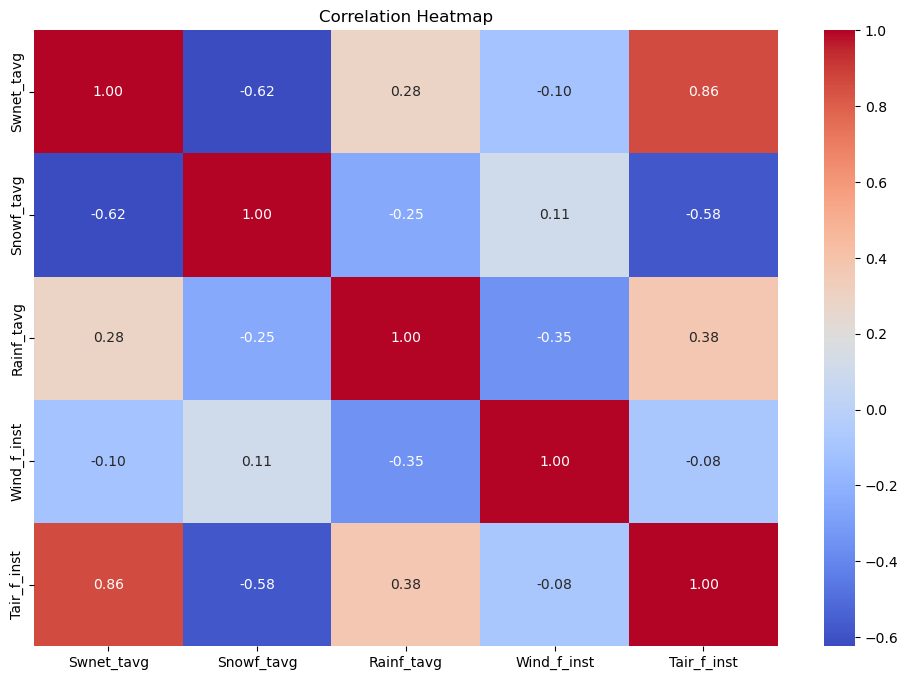

In [14]:
#heatmap to see correlation, remoeve time, lon, lat columns
plt.figure(figsize=(12,8))
correlation_matrix = df.drop(columns=['time', 'lon', 'lat']).corr()
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Correlation Heatmap')

In [15]:
#Compute average for all metrics group by  lon, lat
avg_metrics = df.groupby(['lon', 'lat']).mean().reset_index()
avg_metrics.head()  


,lon,lat,time,Swnet_tavg,Snowf_tavg,Rainf_tavg,Wind_f_inst,Tair_f_inst
0,-179.5,66.5,2023-12-16 10:00:00,52.203139,0.000012,0.000007,2.832950,264.664877
1,-179.5,67.5,2023-12-16 10:00:00,50.401315,0.000013,0.000005,2.059787,261.595445
2,-179.5,68.5,2023-12-16 10:00:00,41.756037,0.000014,0.000004,2.504325,261.790296
3,-179.5,71.5,2023-12-16 10:00:00,37.041782,0.000008,0.000002,3.664381,260.665906
4,-178.5,66.5,2023-12-16 10:00:00,50.802381,0.000014,0.000005,3.119755,262.623820


In [22]:
#create threshold to clasify monthly pattern 
'''
We will use the annual average method to classify weather patterns based on the following criteria:
Classify Snowy if its Cold and Snowy
Classify rain if it high rainfall 
Classify Windy if windy is strong 
Sunny Other wise ,
Cloudy will be classified in Cloud dataset

'''

#Join data with their annual metric s average in avg_metrics
df = pd.merge(df, avg_metrics, on=['lon', 'lat'], suffixes=('', '_avg'))
df.head()

,time,lon,lat,Swnet_tavg,Snowf_tavg,Rainf_tavg,Wind_f_inst,Tair_f_inst,Month,time_avg,Swnet_tavg_avg,Snowf_tavg_avg,Rainf_tavg_avg,Wind_f_inst_avg,Tair_f_inst_avg
0,2023-01-01,-179.5,66.5,0.889153,0.000012,0.0,3.502832,248.41788,1,2023-12-16 10:00:00,52.203139,0.000012,0.000007,2.832950,264.664877
1,2023-01-01,-179.5,67.5,0.585806,0.000013,0.0,2.091139,245.06335,1,2023-12-16 10:00:00,50.401315,0.000013,0.000005,2.059787,261.595445
2,2023-01-01,-179.5,68.5,0.290484,0.000014,0.0,2.810090,245.53134,1,2023-12-16 10:00:00,41.756037,0.000014,0.000004,2.504325,261.790296
3,2023-01-01,-179.5,71.5,0.007903,0.000005,0.0,3.858478,245.66441,1,2023-12-16 10:00:00,37.041782,0.000008,0.000002,3.664381,260.665906
4,2023-01-01,-178.5,66.5,1.018427,0.000012,0.0,3.856865,246.43977,1,2023-12-16 10:00:00,50.802381,0.000014,0.000005,3.119755,262.623820


In [23]:
#label weather pattern
def classify_weather(row):
    if row['Tair_f_inst'] < row['Tair_f_inst_avg'] and row['Snowf_tavg'] > row['Snowf_tavg_avg']:
        return 'Snowy'
    elif row['Rainf_tavg'] > row['Rainf_tavg_avg']:
        return 'Rainy'
    else:
        return 'Sunny'

df['Weather_Pattern'] = df.apply(classify_weather, axis=1)

In [24]:
#Get a month column from time column
df['Month'] = df['time'].dt.month 
df.head()

,time,lon,lat,Swnet_tavg,Snowf_tavg,Rainf_tavg,Wind_f_inst,Tair_f_inst,Month,time_avg,Swnet_tavg_avg,Snowf_tavg_avg,Rainf_tavg_avg,Wind_f_inst_avg,Tair_f_inst_avg,Weather_Pattern
0,2023-01-01,-179.5,66.5,0.889153,0.000012,0.0,3.502832,248.41788,1,2023-12-16 10:00:00,52.203139,0.000012,0.000007,2.832950,264.664877,Sunny
1,2023-01-01,-179.5,67.5,0.585806,0.000013,0.0,2.091139,245.06335,1,2023-12-16 10:00:00,50.401315,0.000013,0.000005,2.059787,261.595445,Snowy
2,2023-01-01,-179.5,68.5,0.290484,0.000014,0.0,2.810090,245.53134,1,2023-12-16 10:00:00,41.756037,0.000014,0.000004,2.504325,261.790296,Sunny
3,2023-01-01,-179.5,71.5,0.007903,0.000005,0.0,3.858478,245.66441,1,2023-12-16 10:00:00,37.041782,0.000008,0.000002,3.664381,260.665906,Sunny
4,2023-01-01,-178.5,66.5,1.018427,0.000012,0.0,3.856865,246.43977,1,2023-12-16 10:00:00,50.802381,0.000014,0.000005,3.119755,262.623820,Sunny


In [27]:
# count weather pattern
df['Weather_Pattern'].value_counts(normalize=True)

Weather_Pattern
Sunny    0.445244
Rainy    0.366661
Snowy    0.188095
Name: proportion, dtype: float64

In [28]:
# Drop unneeded columns
df_model = df[['Month', 'lon', 'lat', 'Weather_Pattern']]
df_model.head()

,Month,lon,lat,Weather_Pattern
0,1,-179.5,66.5,Sunny
1,1,-179.5,67.5,Snowy
2,1,-179.5,68.5,Sunny
3,1,-179.5,71.5,Sunny
4,1,-178.5,66.5,Sunny


**Encoding Data**

In [33]:
# Encode cyclical month features
# --------------------------
df_model["month_sin"] = np.sin(2 * np.pi * df_model["Month"] / 12)
df_model["month_cos"] = np.cos(2 * np.pi * df_model["Month"] / 12)

# --------------------------
# Normalize lat/lon
# --------------------------
df_model["lat_norm"] = (df_model["lat"] - df_model["lat"].min()) / (df_model["lat"].max() - df_model["lat"].min())
df_model["lon_norm"] = (df_model["lon"] - df_model["lon"].min()) / (df_model["lon"].max() - df_model["lon"].min())

# --------------------------
# Encode weather pattern (label)
# --------------------------
le = LabelEncoder()
df_model["Weather_Label"] = le.fit_transform(df_model["Weather_Pattern"])

# --------------------------
# Select features and target
# --------------------------
X = df_model[["month_sin", "month_cos", "lat_norm", "lon_norm"]]
y = df_model["Weather_Label"]

# Optional scaling (some models benefit)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# --------------------------
# Train/test split
# --------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, random_state=42, stratify=y
)

print("✅ Preprocessing complete!")
print("Features shape:", X_train.shape)
print("Labels:", le.classes_)

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_18288\964952154.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_model["month_sin"] = np.sin(2 * np.pi * df_model["Month"] / 12)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_18288\964952154.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_model["month_cos"] = np.cos(2 * np.pi * df_model["Month"] / 12)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_18288\964952154.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Data

✅ Preprocessing complete!
Features shape: (509342, 4)
Labels: ['Rainy' 'Snowy' 'Sunny']


# Train models

In [34]:
# Train Random Classifiers, XGB Classifier, logistics regression, Gradiant boosting classifiers models at the same time loop 
models = {
    "Random Forest": RandomForestClassifier(random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=200, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42)
}

results = {}
for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    results[name] = {
        "Accuracy": accuracy,
        "F1 Score": f1,
        "Classification Report": classification_report(y_test, y_pred, target_names=le.classes_),
        "Confusion Matrix": confusion_matrix(y_test, y_pred)
    }
    
    print(f"{name} - Accuracy: {accuracy:.4f}, F1 Score: {f1:.4f}")
    print("Classification Report:\n", results[name]["Classification Report"])
    print("Confusion Matrix:\n", results[name]["Confusion Matrix"])
    print("-" * 50)


    

Training Random Forest...
Random Forest - Accuracy: 0.7835, F1 Score: 0.7835
Classification Report:
               precision    recall  f1-score   support

       Rainy       0.79      0.79      0.79     80038
       Snowy       0.79      0.79      0.79     41059
       Sunny       0.77      0.77      0.77     97193

    accuracy                           0.78    218290
   macro avg       0.79      0.79      0.79    218290
weighted avg       0.78      0.78      0.78    218290

Confusion Matrix:
 [[63617  1353 15068]
 [ 1311 32626  7122]
 [15101  7309 74783]]
--------------------------------------------------
Training XGBoost...


c:\Users\LENOVO\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [13:44:48] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost - Accuracy: 0.8237, F1 Score: 0.8235
Classification Report:
               precision    recall  f1-score   support

       Rainy       0.83      0.83      0.83     80038
       Snowy       0.81      0.87      0.84     41059
       Sunny       0.82      0.80      0.81     97193

    accuracy                           0.82    218290
   macro avg       0.82      0.83      0.83    218290
weighted avg       0.82      0.82      0.82    218290

Confusion Matrix:
 [[66535  1355 12148]
 [  860 35796  4403]
 [12935  6775 77483]]
--------------------------------------------------
Training Logistic Regression...
Logistic Regression - Accuracy: 0.5947, F1 Score: 0.5931
Classification Report:
               precision    recall  f1-score   support

       Rainy       0.59      0.53      0.55     80038
       Snowy       0.71      0.77      0.74     41059
       Sunny       0.55      0.58      0.56     97193

    accuracy                           0.59    218290
   macro avg       0.61      0.

# Train on Chapion Model

In [36]:
#Train data on XGBoost Classifier with grid search cv
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2]
}   
xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)
print("Best parameters found: ", grid_search.best_params_)
best_xgb = grid_search.best_estimator_
y_pred = best_xgb.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
print(f"XGBoost after Grid Search - Accuracy: {accuracy:.4f}, F1 Score: {f1:.4f}")


Fitting 3 folds for each of 27 candidates, totalling 81 fits


c:\Users\LENOVO\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [13:57:47] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best parameters found:  {'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 150}
XGBoost after Grid Search - Accuracy: 0.8303, F1 Score: 0.8301


In [40]:
#See all feautures importance
importances = best_xgb.feature_importances_
feature_names = ["month_sin", "month_cos", "lat_norm", "lon_norm"]
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
print(feature_importance_df)

     Feature  Importance
1  month_cos    0.400760
2   lat_norm    0.250619
0  month_sin    0.240392
3   lon_norm    0.108230


In [41]:
df_model

,Month,lon,lat,Weather_Pattern,month_sin,month_cos,lat_norm,lon_norm,Weather_Label
0,1,-179.5,66.5,Sunny,5.000000e-01,0.866025,0.876812,0.000000,2
1,1,-179.5,67.5,Snowy,5.000000e-01,0.866025,0.884058,0.000000,1
2,1,-179.5,68.5,Sunny,5.000000e-01,0.866025,0.891304,0.000000,2
3,1,-179.5,71.5,Sunny,5.000000e-01,0.866025,0.913043,0.000000,2
4,1,-178.5,66.5,Sunny,5.000000e-01,0.866025,0.876812,0.002786,2
...,...,...,...,...,...,...,...,...,...
727627,12,178.5,68.5,Snowy,-2.449294e-16,1.000000,0.891304,0.997214,1
727628,12,179.5,65.5,Snowy,-2.449294e-16,1.000000,0.869565,1.000000,1
727629,12,179.5,66.5,Snowy,-2.449294e-16,1.000000,0.876812,1.000000,1
727630,12,179.5,67.5,Snowy,-2.449294e-16,1.000000,0.884058,1.000000,1


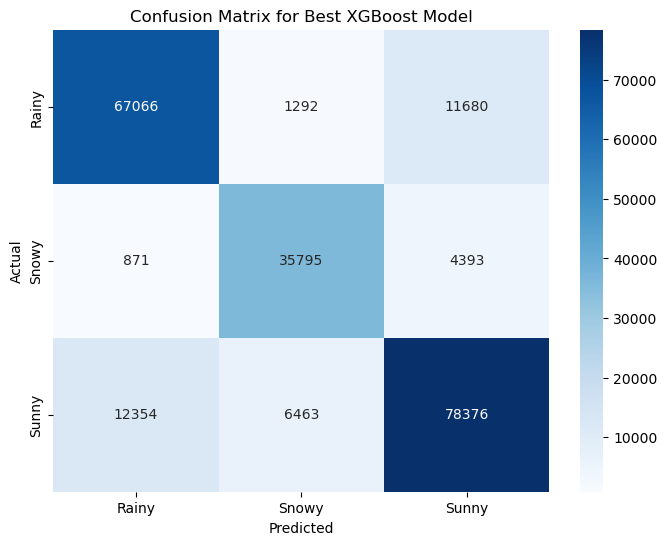

In [37]:
#Confusion matrix for the best_xgb 
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Best XGBoost Model')
# --- IGNORE ---
plt.show()

🔹 2. Overall Performance – The model performs strongly overall; most predictions fall on the diagonal. Main confusion is between Sunny ↔ Rainy and Snowy ↔ Sunny.

🔹 3. Class Accuracy –

Rainy: ~83.8% accuracy, some days misread as Sunny.

Snowy: ~86.8% accuracy, clearest separation due to low temps.

Sunny: ~80.1% accuracy, often confused with Rainy.

🔹 4. Insights – “Snowy” is easiest to classify, while “Sunny” and “Rainy” share overlapping features (e.g., temperature, radiation). Sunny likely dominates the dataset.

🔹 5. Improvements – Add cloud fraction, humidity, or pressure; balance classes; and use probability calibration or thresholds to reduce Sunny–Rainy overlap.

🔹 6. Summary – XGBoost achieves ~83–86% class accuracy overall. Snowy classification is most reliable, and minor feature engineering could further enhance distinction between Sunny and Rainy.

In [38]:
#import pickle to save the model
import pickle
with open(r"D:\Oklo_weather_prediction\Models\XGB_Classifier.pkl", 'wb') as f:
    pickle.dump(best_xgb, f)




